In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as rmse, r2_score as r2

In [67]:
df = pd.read_csv(r"prepared_dataset.csv").drop("id", axis=1)
df.head()

,RAM_size,CPU_clock_speed_(GHz),drive_memory_size_(GB),buynow_price,graphic_card_type_integrated graphics,resolution_(px)_1366 x 768,resolution_(px)_1600 x 900,resolution_(px)_1920 x 1080,resolution_(px)_1920 x 1200,resolution_(px)_1920 x 1280,...,operating_system_windows 8.1 home 32-bit,operating_system_windows 8.1 home 64-bit,operating_system_windows 8.1 professional 32-bit,operating_system_windows 8.1 professional 64-bit,input_devices_keyboard,input_devices_numeric keyboard,input_devices_touchpad,multimedia_camera,multimedia_microphone,multimedia_speakers
0,8,2.0,1000.0,2369.0,0,0,0,1,0,0,...,0,0,0,0,1,0,1,1,1,0
1,4,2.0,240.0,2299.0,1,0,0,1,0,0,...,0,0,0,0,1,0,1,1,1,0
2,16,2.8,1500.0,5999.0,0,0,0,1,0,0,...,0,0,0,0,1,1,1,1,1,1
3,4,1.6,500.0,1299.0,1,1,0,0,0,0,...,0,0,0,0,1,1,1,1,1,1
4,4,2.4,500.0,3329.0,1,1,0,0,0,0,...,0,0,0,0,1,0,1,1,1,1


## Splitting dataset

In [68]:
# create polynomial features
poly_columns = df.iloc[:, :3]
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(poly_columns)
poly_features = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(poly_columns.columns))

In [69]:
X = pd.concat([poly_features, df.iloc[:, 4:]], axis=1)
y = np.log(df["buynow_price"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

## Linear regression 

In [70]:
linear_regression = LinearRegression().fit(X_train, y_train)

metrics = ["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"]
validation = cross_validate(linear_regression, X_train, y_train, cv=5, scoring=metrics)
print("cross validation performance")
{k:abs(np.mean(v)).round(3) for k, v in validation.items()}

cross validation performance


{'fit_time': 0.013,
 'score_time': 0.005,
 'test_r2': 0.894,
 'test_neg_mean_absolute_error': 0.118,
 'test_neg_root_mean_squared_error': 0.157}

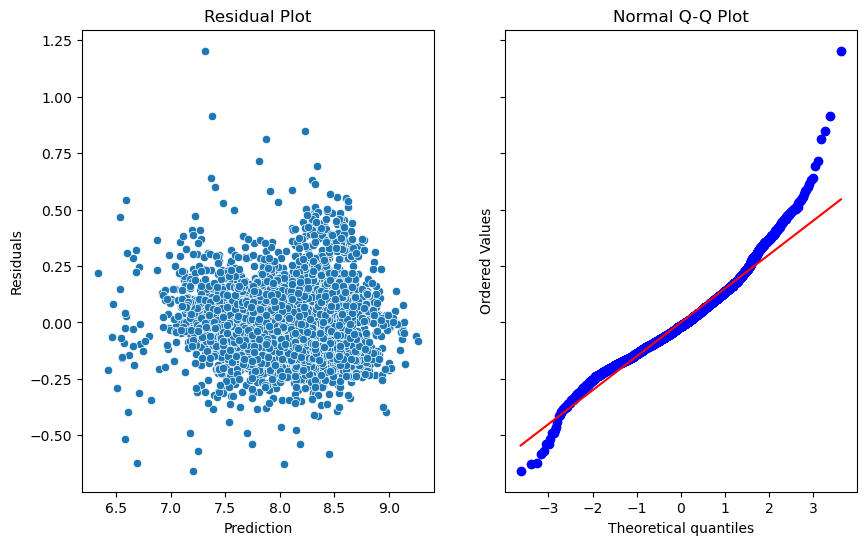

In [71]:
# Residual plot + Q-Q plot
predictions = linear_regression.predict(X_train)
residuals = y_train - predictions
fig, ax = plt.subplots(1, 2, sharey="all", figsize=(10, 6))

sns.scatterplot(x=predictions, y=residuals, ax=ax[0])
ax[0].set_title("Residual Plot")
ax[0].set_xlabel("Prediction")
ax[0].set_ylabel("Residuals")

stats.probplot(residuals, dist="norm", plot=ax[1])
ax[1].set_title("Normal Q-Q Plot")

plt.show();

Small curve patterns at the beginning and end of the Q-Q plot, indicating deviations from the expected error distribution. Not good sign for model

## Regularized regressions

In [72]:
# scaling dataset
scaler = StandardScaler().fit(X_train)
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)

# hyperparameters
alpha_values = 10 ** np.linspace(-3, 3, 200)
l1_ratios = np.linspace(0.01, 1, 20)

In [73]:
# L1, L2 and ElasticNet
lasso_model = LassoCV(alphas=alpha_values, cv=5).fit(X_train_scale, y_train)
ridge_model = RidgeCV(alphas=alpha_values, cv=5).fit(X_train_scale, y_train)
enet_model = ElasticNetCV(alphas=alpha_values, l1_ratio=l1_ratios, cv=5).fit(X_train_scale, y_train)

## Models performance

In [83]:
# function to estimate key metrics for regressions
def model_performance(model, X, y):
    labels = ["R2", "MAE", "RMSE"]
    
    r2_score = r2(np.exp(y), np.exp(model.predict(X))).round(3)
    mae_score = mae(np.exp(y), np.exp(model.predict(X))).round(3)
    rmse_score = rmse(np.exp(y), np.exp(model.predict(X)), squared=False).round(3)
    values = [r2_score, mae_score, rmse_score]

    return pd.DataFrame({"value": values}, index=labels)

### Training results

In [85]:
m1 = model_performance(linear_regression, X_train, y_train).rename(columns={"value": "linear_regression"})
m2 = model_performance(lasso_model, X_train_scale, y_train).rename(columns={"value": "lasso_model"})
m3 = model_performance(ridge_model, X_train_scale, y_train).rename(columns={"value": "ridge_model"})
m4 = model_performance(enet_model, X_train_scale, y_train).rename(columns={"value": "enet_model"})

train_result = pd.concat([m1, m2, m3, m4], axis=1)
train_result 

,linear_regression,lasso_model,ridge_model,enet_model
R2,0.842,0.840,0.842,0.842
MAE,437.864,442.247,437.902,438.300
RMSE,662.607,667.400,662.687,663.269


### Test results

In [86]:
m1 = model_performance(linear_regression, X_test, y_test).rename(columns={"value": "linear_regression"})
m2 = model_performance(lasso_model, X_test_scale, y_test).rename(columns={"value": "lasso_model"})
m3 = model_performance(ridge_model, X_test_scale, y_test).rename(columns={"value": "ridge_model"})
m4 = model_performance(enet_model, X_test_scale, y_test).rename(columns={"value": "enet_model"})

test_result = pd.concat([m1, m2, m3, m4], axis=1)
test_result

,linear_regression,lasso_model,ridge_model,enet_model
R2,0.820,0.818,0.820,0.820
MAE,430.896,433.665,430.929,431.122
RMSE,651.208,655.564,651.265,651.708
